In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/zinc250k/250k_rndm_zinc_drugs_clean_3.csv


In [30]:
!pip install rdkit

In [31]:
!pip install torch_geometric

In [32]:
!pip install torch

In [33]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from sklearn.model_selection import train_test_split
from torch_geometric.nn import GCNConv, global_mean_pool
from tqdm import tqdm
from rdkit import Chem
import seaborn as sns

In [34]:
# Set device to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [35]:
# Load the dataset and select a subset of 10,000 rows
df = pd.read_csv('/kaggle/input/zinc250k/250k_rndm_zinc_drugs_clean_3.csv')  # Adjust path to your dataset
df_subset = df.head(50000)  # Select the first 10,000 rows

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


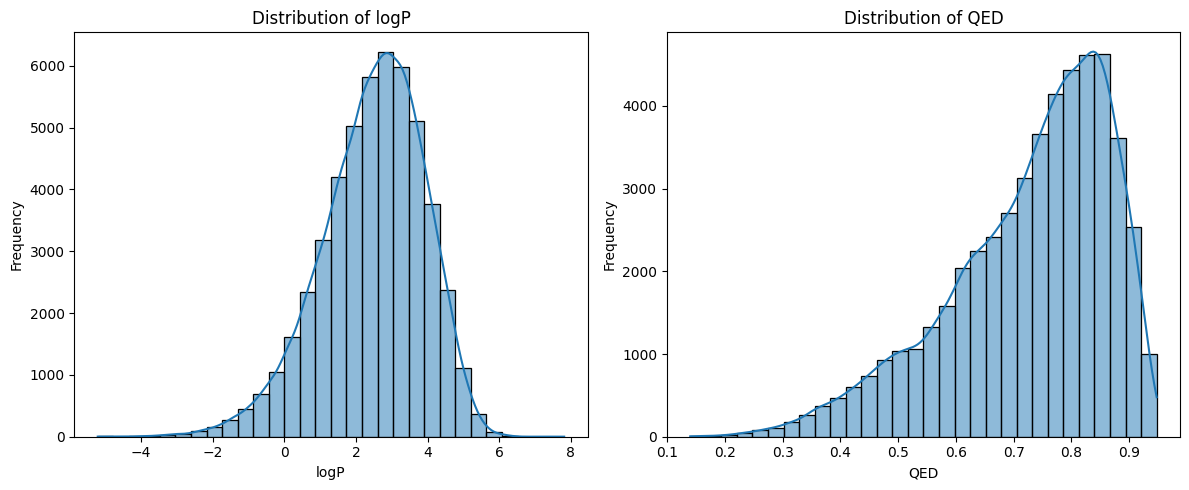

In [36]:
# EDA - Visualizing the distribution of logP, QED, and SAS
plt.figure(figsize=(12, 5))

# LogP distribution
plt.subplot(1, 2, 1)
sns.histplot(df_subset['logP'], bins=30, kde=True)
plt.title('Distribution of logP')
plt.xlabel('logP')
plt.ylabel('Frequency')

# QED distribution
plt.subplot(1, 2, 2)
sns.histplot(df_subset['qed'], bins=30, kde=True)
plt.title('Distribution of QED')
plt.xlabel('QED')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [37]:
# Correlation matrix for logP, QED, and SAS (if SAS exists)
if 'SAS' in df_subset.columns:
    correlation_df = df_subset[['logP', 'qed', 'SAS']]
else:
    correlation_df = df_subset[['logP', 'qed']]

correlation_matrix = correlation_df.corr()
print("Correlation matrix:\n", correlation_matrix)

Correlation matrix:
           logP       qed       SAS
logP  1.000000 -0.177761 -0.512706
qed  -0.177761  1.000000  0.104757
SAS  -0.512706  0.104757  1.000000


In [38]:
# Dropping missing values
df_subset = df_subset.dropna()

In [39]:
from sklearn.preprocessing import MinMaxScaler
# Normalize target properties (logP, QED, and SAS) for the subset
scaler = MinMaxScaler()
df_subset[['logP', 'qed', 'SAS']] = scaler.fit_transform(df_subset[['logP', 'qed', 'SAS']])


In [40]:
# Function to convert SMILES to molecular graphs using PyTorch Geometric
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    # Get atomic numbers as node features
    atom_features = [atom.GetAtomicNum() for atom in mol.GetAtoms()]
    edge_index = []
    edge_attr = []

    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index.append((i, j))
        edge_index.append((j, i))  # Undirected graph

        edge_type = bond.GetBondTypeAsDouble()
        edge_attr.append(edge_type)
        edge_attr.append(edge_type)  # Undirected graph

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    x = torch.tensor(atom_features, dtype=torch.float).view(-1, 1)  # Node features
    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)  # Edge features

    return Data(x=x, edge_index=edge_index, edge_attr=edge_attr)

In [41]:
# Convert SMILES strings to molecular graphs
graphs = []

for smiles in tqdm(df_subset['smiles'], desc="Processing SMILES", total=len(df_subset['smiles'])):
    graph = smiles_to_graph(smiles)
    if graph is not None:
        graphs.append(graph)

# No need to concatenate embeddings, just proceed with the graph data


Processing SMILES: 100%|██████████| 50000/50000 [00:36<00:00, 1370.31it/s]


In [51]:
# Create separate data lists for (logP, QED) and SAS models for the subset
logp_qed_data = []
sas_data = []

for i, graph in enumerate(graphs):
    logp, qed, sas = df_subset.iloc[i][['logP', 'qed', 'SAS']]
    
    # Append (logP, QED) data
    logp_qed_graph = graph.clone()
    logp_qed_graph.y = torch.tensor([logp, qed], dtype=torch.float).view(1, 2)  # Ensure shape is [1, 2]
    logp_qed_data.append(logp_qed_graph)

    # Append SAS data
    sas_graph = graph.clone()
    sas_graph.y = torch.tensor([sas], dtype=torch.float).view(1, 1)  # Ensure shape is [1, 1]
    sas_data.append(sas_graph)


In [52]:
from sklearn.model_selection import train_test_split

# Split data into train, validation, and test sets (Subset of 50K)
logp_qed_train, logp_qed_temp = train_test_split(logp_qed_data, test_size=0.3, random_state=42)  # 70% train, 30% temp
logp_qed_val, logp_qed_test = train_test_split(logp_qed_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

sas_train, sas_temp = train_test_split(sas_data, test_size=0.3, random_state=42)  # 70% train, 30% temp
sas_val, sas_test = train_test_split(sas_temp, test_size=0.5, random_state=42)  # 15% val, 15% test

# Create DataLoaders for train, validation, and test sets
logp_qed_train_loader = DataLoader(logp_qed_train, batch_size=32, shuffle=True)
logp_qed_val_loader = DataLoader(logp_qed_val, batch_size=32, shuffle=False)  # Validation loader
logp_qed_test_loader = DataLoader(logp_qed_test, batch_size=32, shuffle=False)

sas_train_loader = DataLoader(sas_train, batch_size=32, shuffle=True)
sas_val_loader = DataLoader(sas_val, batch_size=32, shuffle=False)  # Validation loader
sas_test_loader = DataLoader(sas_test, batch_size=32, shuffle=False)


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.nn import GINConv, global_mean_pool, BatchNorm, Set2Set
import matplotlib.pyplot as plt

class ImprovedGIN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):
        super(ImprovedGIN, self).__init__()
        self.layers = torch.nn.ModuleList()

        # First layer
        nn1 = torch.nn.Sequential(
            torch.nn.Linear(input_dim, hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim, hidden_dim)
        )
        self.layers.append(GINConv(nn1))

        # Additional GIN layers
        for _ in range(num_layers - 1):
            nn = torch.nn.Sequential(
                torch.nn.Linear(hidden_dim, hidden_dim),
                torch.nn.ReLU(),
                torch.nn.Linear(hidden_dim, hidden_dim)
            )
            self.layers.append(GINConv(nn))
        
        self.fc = torch.nn.Linear(hidden_dim, output_dim)
        self.bn = torch.nn.BatchNorm1d(hidden_dim)
    
    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        for conv in self.layers:
            x = F.relu(conv(x, edge_index))
            x = self.bn(x)
        
        # Global pooling
        x = global_mean_pool(x, data.batch)
        
        return self.fc(x)







In [67]:
# Initialize separate models for (logP, QED) and SAS using GIN
input_dim = graphs[0].x.shape[1]  # Get input dimension from graph node features
hidden_dim = 64

# Define GIN models for logP/QED and SAS prediction
logp_qed_model = GIN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=2).to(device)  # 2 outputs: logP and QED
sas_model = GIN(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=1).to(device)  # 1 output: SAS

# Define Mean Squared Error Loss (for regression tasks)
criterion = torch.nn.MSELoss()

# Define optimizers for both models
logp_qed_optimizer = optim.AdamW(logp_qed_model.parameters(), lr=0.001, weight_decay=1e-5)  # AdamW optimizer with weight decay
sas_optimizer = optim.AdamW(sas_model.parameters(), lr=0.001, weight_decay=1e-5)  # Lowered learning rate for SAS model

# Both models will be trained using MSE loss and their respective optimizers


In [68]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np

# Training function
def train(model, loader, optimizer):
    model.train()
    total_loss = 0
    for data in loader:
        data = data.to(device)  # Ensure data is on the correct device
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.num_graphs
    return total_loss / len(loader.dataset)

# Evaluation function with all metrics
def evaluate(model, loader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for data in loader:
            data = data.to(device)
            out = model(data)
            y_true.extend(data.y.cpu().numpy())  # Collect actual values
            y_pred.extend(out.cpu().numpy())  # Collect predicted values

    # Convert lists to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)

    # Print metrics
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")
    print(f"MAPE: {mape:.4f}")

    # Return all metrics
    return {
        "mse": mse,
        "rmse": rmse,
        "mae": mae,
        "r2": r2,
        "mape": mape
    }


MSE: 0.0202
RMSE: 0.1422
MAE: 0.1127
R²: 0.0465
MAPE: 0.2075
MSE: 0.0184
RMSE: 0.1358
MAE: 0.1071
R²: 0.0677
MAPE: 0.4566
Epoch 1/15 - logP/QED Loss: 0.0262
logP/QED Metrics: MSE: 0.0202, RMSE: 0.1422, MAE: 0.1127, R²: 0.0465, MAPE: 0.2075
Epoch 1/15 - SAS Loss: 0.0210
SAS Metrics: MSE: 0.0184, RMSE: 0.1358, MAE: 0.1071, R²: 0.0677, MAPE: 0.4566
MSE: 0.0206
RMSE: 0.1437
MAE: 0.1090
R²: 0.0084
MAPE: 0.2171
MSE: 0.0173
RMSE: 0.1316
MAE: 0.1014
R²: 0.1246
MAPE: 0.4030
Epoch 2/15 - logP/QED Loss: 0.0216
logP/QED Metrics: MSE: 0.0206, RMSE: 0.1437, MAE: 0.1090, R²: 0.0084, MAPE: 0.2171
Epoch 2/15 - SAS Loss: 0.0186
SAS Metrics: MSE: 0.0173, RMSE: 0.1316, MAE: 0.1014, R²: 0.1246, MAPE: 0.4030
MSE: 0.0205
RMSE: 0.1433
MAE: 0.1060
R²: 0.0656
MAPE: 0.2124
MSE: 0.0165
RMSE: 0.1284
MAE: 0.1040
R²: 0.1669
MAPE: 0.4752
Epoch 3/15 - logP/QED Loss: 0.0209
logP/QED Metrics: MSE: 0.0205, RMSE: 0.1433, MAE: 0.1060, R²: 0.0656, MAPE: 0.2124
Epoch 3/15 - SAS Loss: 0.0179
SAS Metrics: MSE: 0.0165, RMSE: 0.

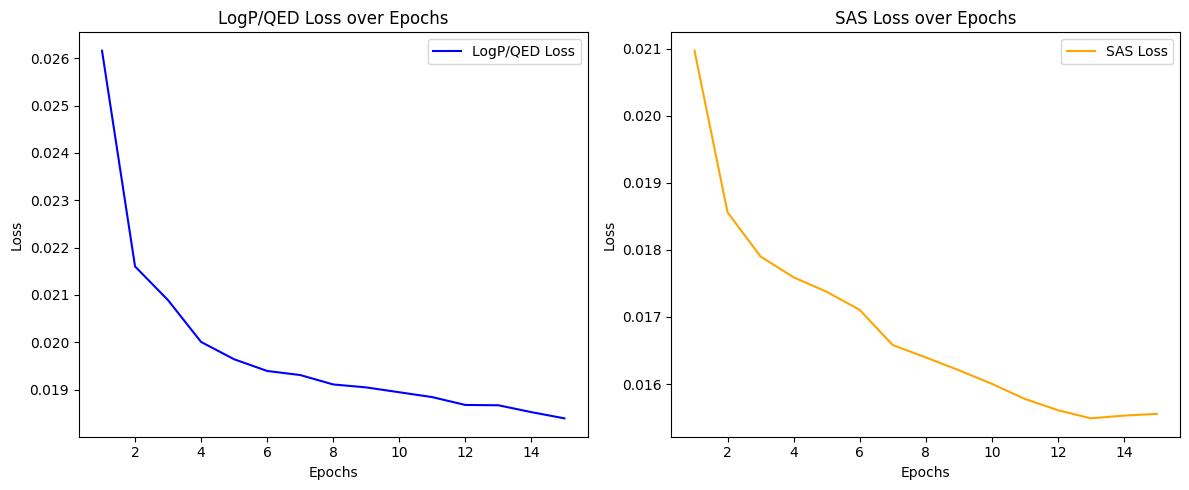

In [69]:
import matplotlib.pyplot as plt

# Lists to store metrics
logp_qed_losses = []
sas_losses = []
logp_qed_metrics_list = []
sas_metrics_list = []

# Train both models for 15 epochs and evaluate them
epochs = 15
for epoch in range(epochs):
    logp_qed_loss = train(logp_qed_model, logp_qed_train_loader, logp_qed_optimizer)
    logp_qed_metrics = evaluate(logp_qed_model, logp_qed_test_loader)  # All metrics for logP/QED
    
    sas_loss = train(sas_model, sas_train_loader, sas_optimizer)
    sas_metrics = evaluate(sas_model, sas_test_loader)  # All metrics for SAS
    
    # Store losses and metrics
    logp_qed_losses.append(logp_qed_loss)
    sas_losses.append(sas_loss)
    logp_qed_metrics_list.append(logp_qed_metrics)
    sas_metrics_list.append(sas_metrics)

    # Print metrics for logP/QED
    print(f"Epoch {epoch+1}/{epochs} - logP/QED Loss: {logp_qed_loss:.4f}")
    print(f"logP/QED Metrics: MSE: {logp_qed_metrics['mse']:.4f}, RMSE: {logp_qed_metrics['rmse']:.4f}, "
          f"MAE: {logp_qed_metrics['mae']:.4f}, R²: {logp_qed_metrics['r2']:.4f}, MAPE: {logp_qed_metrics['mape']:.4f}")

    # Print metrics for SAS
    print(f"Epoch {epoch+1}/{epochs} - SAS Loss: {sas_loss:.4f}")
    print(f"SAS Metrics: MSE: {sas_metrics['mse']:.4f}, RMSE: {sas_metrics['rmse']:.4f}, "
          f"MAE: {sas_metrics['mae']:.4f}, R²: {sas_metrics['r2']:.4f}, MAPE: {sas_metrics['mape']:.4f}")

# Plotting loss curves
plt.figure(figsize=(12, 5))

# Plot for logP/QED Loss
plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), logp_qed_losses, label='LogP/QED Loss', color='blue')
plt.title('LogP/QED Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot for SAS Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), sas_losses, label='SAS Loss', color='orange')
plt.title('SAS Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()
